In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from sklearn.ensemble import HistGradientBoostingRegressor

def sharpe_ratio_np(returns, freq: int = 252) -> float:
    returns = np.asarray(returns, dtype=float)
    if returns.std() == 0:
        return 0.0
    return np.sqrt(freq) * returns.mean() / returns.std()


PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2


from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)




C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [2]:
# Load SP500 panel, as long as we can reasonably go

prices = load_sp500_adj_close(start="2000-01-01", force_download=True)

prices.info()
prices.head()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))


Universe size from CSV: 503
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 50)



1 Failed download:
['DD']: Timeout('Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


  -> No valid columns after mapping, skipping.
  -> Batch close shape: (6530, 50)
  -> Batch close shape: (6530, 3)
Final price panel shape: (6530, 453)
Saved S&P 500 adj close to C:\Users\gehra\Documents\GitHub\Quant_coding\data\sp500_adj_close.parquet
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6530 entries, 2000-01-03 to 2025-12-17
Columns: 453 entries, NVDA to NWS
dtypes: float64(453)
memory usage: 22.6 MB
Price panel shape: (6530, 453)
Date range: 2000-01-03 00:00:00 -> 2025-12-17 00:00:00
Number of tickers: 453


In [3]:
lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

signals_df.head()
print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))




c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2505045, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Unique tickers in signals: 451


X shape: (2505045, 11)
y shape: (2505045,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Num unique tickers: 451


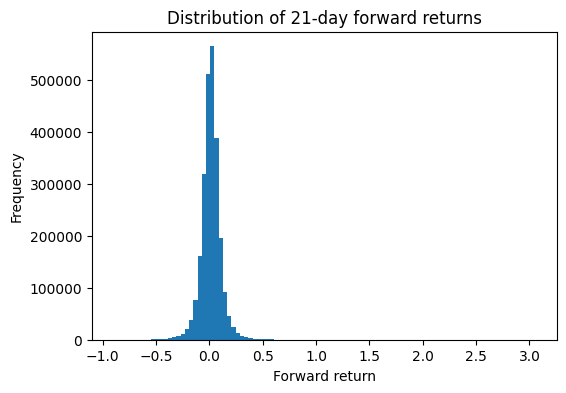

In [4]:
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity checks on target distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [5]:
# --- Date-based split: train / val / test ---

unique_dates = np.array(sorted(dates.unique()))
n_dates = len(unique_dates)
print("Number of trading days in panel:", n_dates)

# 60% train, 20% val, 20% test by time
train_end = unique_dates[int(n_dates * 0.6)]
val_end   = unique_dates[int(n_dates * 0.8)]

print("Train end date:", train_end)
print("Val   end date:", val_end)

mask_train = dates <= train_end
mask_val   = (dates > train_end) & (dates <= val_end)
mask_test  = dates > val_end

X_train, y_train = X[mask_train], y[mask_train]
X_val,   y_val   = X[mask_val],   y[mask_val]
X_test,  y_test  = X[mask_test],  y[mask_test]

dates_train = dates[mask_train]
dates_val   = dates[mask_val]
dates_test  = dates[mask_test]

tickers_train = tickers[mask_train]
tickers_val   = tickers[mask_val]
tickers_test  = tickers[mask_test]


print("Train samples:", len(y_train))
print("Val   samples:", len(y_val))
print("Test  samples:", len(y_test))


Number of trading days in panel: 6310
Train end date: 2015-11-04 00:00:00
Val   end date: 2020-11-09 00:00:00
Train samples: 1400738
Val   samples: 541584
Test  samples: 562723


In [6]:
# --- Baseline cross-sectional momentum on TEST period ---

# We'll use signals_df again but only for dates > val_end
idx_dates = signals_df.index.get_level_values("date")
signals_test = signals_df.loc[idx_dates > val_end].copy()

signals_test.head()


ret_1     ret_5    ret_10    ret_21    vol_10    vol_20  \
date       ticker                                                               
2020-11-10 NVDA   -0.063148 -0.019164 -0.046784 -0.102348  0.047047  0.034437   
           AAPL   -0.003009  0.051884 -0.003687 -0.066157  0.033712  0.024649   
           MSFT   -0.033793  0.022186 -0.010504 -0.046929  0.030081  0.022744   
           AMZN   -0.034583 -0.004392 -0.076471 -0.118478  0.037701  0.027920   
           GOOGL  -0.013455  0.055941  0.086836  0.110655  0.031301  0.024895   

                     vol_60  ma20_rel  ma50_rel  ma200_rel  target_fwd_21  dow  
date       ticker                                                               
2020-11-10 NVDA    0.032991  0.052217  0.035339  -0.245391       0.016138    1  
           AAPL    0.028765 -0.004100 -0.004305  -0.209831       0.062689    1  
           MSFT    0.022365  0.011737  0.001858  -0.094338       0.000290    1  
           AMZN    0.026523  0.053939  0.051427  -0.121350       0.021901    1  
           GOOGL   0.021851 -0.064941 -0.105713  -0.175214       0.017224    1

In [7]:
def compute_cs_daily_returns(df: pd.DataFrame, q: float = 0.1, horizon: int = 21):
    """
    df: index (date, symbol), columns: y_true, y_pred (21d forward returns and predictions)
    Returns three Series of *daily-equivalent* returns:
        eqw, long-only (top q), long-short (top q minus bottom q)
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Equal-weight all stocks -> benchmark
        eqw_ret_21 = group["y_true"].mean()

        # Sort by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]     # worst predicted
        top    = g_sorted.iloc[-k:]    # best predicted

        long_ret_21  = top["y_true"].mean()
        short_ret_21 = bottom["y_true"].mean()

        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily   = to_daily(eqw_ret_21)
        long_daily  = to_daily(long_ret_21)
        short_daily = to_daily(short_ret_21)
        long_short_daily = long_daily - short_daily

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [8]:
def objective_tree_cs(trial):
    # --- Hyperparameters for the tree ---
    max_depth = trial.suggest_int("max_depth", 2, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)

    # --- Trading hyperparameter: how big the long/short buckets are ---
    q = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

    # Train on TRAIN only
    model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train, y_train)

    # Predictions on VALIDATION samples
    y_pred_val = model.predict(X_val)

    df_val = pd.DataFrame(
        {
            "date":   dates_val,
            "symbol": tickers_val,
            "y_true": y_val,
            "y_pred": y_pred_val,
        }
    ).set_index(["date", "symbol"]).sort_index()

    # Build portfolios on validation: EW, long-only, long-short
    _, long_val, long_short_val = compute_cs_daily_returns(df_val, q=q, horizon=21)

    # We care about *market-neutral alpha* → use long-short Sharpe as objective
    ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()

    if len(ret_series) < 20:
        return 0.0  # too little data, treat as bad

    sharpe = sharpe_ratio_np(ret_series.values)
    # Optuna MINIMIZES → return negative Sharpe
    return -sharpe


In [9]:
study_tree_cs = optuna.create_study(direction="minimize")
study_tree_cs.optimize(objective_tree_cs, n_trials=20)

print("Best params:", study_tree_cs.best_params)
print("Best value (negative Sharpe):", study_tree_cs.best_value)


[I 2025-12-18 14:07:40,238] A new study created in memory with name: no-name-b6f82ad2-2395-456a-8cf5-c50d48f849ba
[I 2025-12-18 14:08:27,717] Trial 0 finished with value: -1.7372509391198627 and parameters: {'max_depth': 6, 'learning_rate': 0.16804049898245974, 'max_iter': 184, 'min_samples_leaf': 63, 'q': 0.27745577662849485}. Best is trial 0 with value: -1.7372509391198627.
[I 2025-12-18 14:09:16,940] Trial 1 finished with value: -3.3144195075659177 and parameters: {'max_depth': 3, 'learning_rate': 0.016027476268399284, 'max_iter': 390, 'min_samples_leaf': 119, 'q': 0.09085461540155342}. Best is trial 1 with value: -3.3144195075659177.
[I 2025-12-18 14:09:46,235] Trial 2 finished with value: -3.0148277896312 and parameters: {'max_depth': 2, 'learning_rate': 0.12370555644827154, 'max_iter': 246, 'min_samples_leaf': 71, 'q': 0.10878518584172785}. Best is trial 1 with value: -3.3144195075659177.
[I 2025-12-18 14:10:20,603] Trial 3 finished with value: -2.139682480105057 and parameters: 

Best params: {'max_depth': 3, 'learning_rate': 0.011603996371632957, 'max_iter': 327, 'min_samples_leaf': 157, 'q': 0.056376863838148515}
Best value (negative Sharpe): -3.788662270425851


In [10]:
best_params = study_tree_cs.best_params.copy()
q_best = best_params.pop("q")  # remove q from dict, keep only model params

tree_cs_best = HistGradientBoostingRegressor(
    **best_params,
    random_state=42,
)

# Train on TRAIN + VAL
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

tree_cs_best.fit(X_trainval, y_trainval)

# Predictions on TEST
y_pred_test = tree_cs_best.predict(X_test)

df_test = pd.DataFrame(
    {
        "date":   dates_test,
        "symbol": tickers_test,
        "y_true": y_test,
        "y_pred": y_pred_test,
    }
).set_index(["date", "symbol"]).sort_index()

eqw_tree, tree_long_daily, tree_ls_daily = compute_cs_daily_returns(
    df_test, q=q_best, horizon=21
)


In [11]:
def daily_momentum_cs(group: pd.DataFrame, q: float = 0.1, horizon: int = 21) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()

    # convert 21-day returns to daily-equivalent returns
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily   = to_daily(eqw_ret_21)
    long_ret_daily  = to_daily(long_ret_21)
    short_ret_daily = to_daily(short_ret_21)
    long_short_daily = long_ret_daily - short_ret_daily

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


In [12]:
daily_cs_rets = signals_test.groupby("date").apply(daily_momentum_cs, q=0.1)
daily_cs_rets.head()

eqw_returns        = daily_cs_rets["eqw"]
mom_long_returns   = daily_cs_rets["long"]
mom_ls_returns     = daily_cs_rets["long_short"]


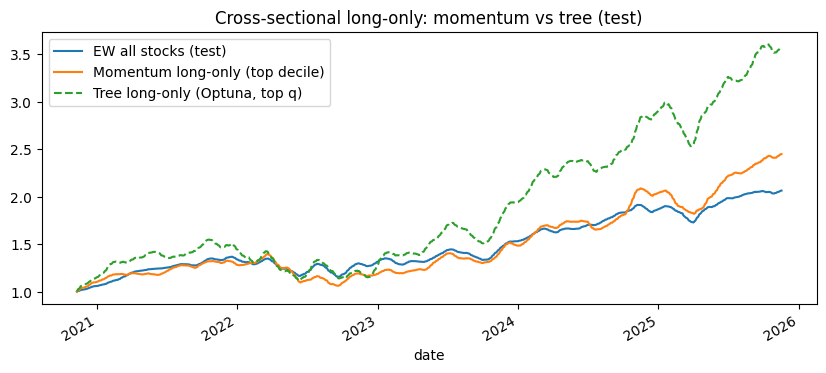

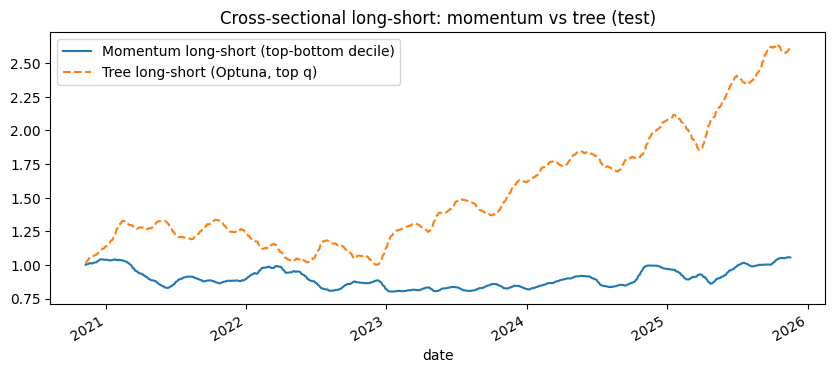

{'eqw_cagr': 0.15543817185489583,
 'eqw_vol': np.float64(0.03182719043224919),
 'eqw_sharpe': np.float64(4.922160391430794),
 'eqw_max_dd': -0.1540140506530363,
 'momL_cagr': 0.19511741613909606,
 'momL_vol': np.float64(0.04081726769872841),
 'momL_sharpe': np.float64(4.828441402672),
 'momL_max_dd': -0.23925303654113694,
 'momLS_cagr': 0.010666351229455584,
 'momLS_vol': np.float64(0.04026040151524595),
 'momLS_sharpe': np.float64(0.29379242557448176),
 'momLS_max_dd': -0.23106537746793654}

In [15]:
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)

equity_eqw     = equity_curve_from_returns(eqw_returns)
equity_mom_L   = equity_curve_from_returns(mom_long_returns)
equity_mom_LS  = equity_curve_from_returns(mom_ls_returns)

# Equity curves for the Optuna-tuned tree strategy
equity_tree_L_opt  = equity_curve_from_returns(tree_long_daily)
equity_tree_LS_opt = equity_curve_from_returns(tree_ls_daily)




# Long-only: EW vs momentum vs tree (Optuna)
plt.figure(figsize=(10, 4))
equity_eqw.plot(label="EW all stocks (test)")
equity_mom_L.plot(label="Momentum long-only (top decile)")
equity_tree_L_opt.plot(label="Tree long-only (Optuna, top q)", linestyle="--")
plt.legend()
plt.title("Cross-sectional long-only: momentum vs tree (test)")
plt.show()

# Long-short: momentum vs tree (Optuna)
plt.figure(figsize=(10, 4))
equity_mom_LS.plot(label="Momentum long-short (top-bottom decile)")
equity_tree_LS_opt.plot(label="Tree long-short (Optuna, top q)", linestyle="--")
plt.legend()
plt.title("Cross-sectional long-short: momentum vs tree (test)")
plt.show()


metrics_cs = {
    "eqw_cagr":     cagr(equity_eqw),
    "eqw_vol":      annualized_vol(eqw_returns),
    "eqw_sharpe":   sharpe_ratio(eqw_returns),
    "eqw_max_dd":   max_drawdown(equity_eqw),

    "momL_cagr":    cagr(equity_mom_L),
    "momL_vol":     annualized_vol(mom_long_returns),
    "momL_sharpe":  sharpe_ratio(mom_long_returns),
    "momL_max_dd":  max_drawdown(equity_mom_L),

    "momLS_cagr":   cagr(equity_mom_LS),
    "momLS_vol":    annualized_vol(mom_ls_returns),
    "momLS_sharpe": sharpe_ratio(mom_ls_returns),
    "momLS_max_dd": max_drawdown(equity_mom_LS),
}
metrics_cs


In [14]:
metrics_tree_cs_opt = {
    "momL_cagr":    cagr(equity_mom_L),
    "momL_vol":     annualized_vol(mom_long_returns),
    "momL_sharpe":  sharpe_ratio(mom_long_returns),
    "momL_max_dd":  max_drawdown(equity_mom_L),

    "treeL_cagr":   cagr(equity_tree_L_opt),
    "treeL_vol":    annualized_vol(tree_long_daily),
    "treeL_sharpe": sharpe_ratio(tree_long_daily),
    "treeL_max_dd": max_drawdown(equity_tree_L_opt),

    "momLS_cagr":   cagr(equity_mom_LS),
    "momLS_vol":    annualized_vol(mom_ls_returns),
    "momLS_sharpe": sharpe_ratio(mom_ls_returns),
    "momLS_max_dd": max_drawdown(equity_mom_LS),

    "treeLS_cagr":  cagr(equity_tree_LS_opt),
    "treeLS_vol":   annualized_vol(tree_ls_daily),
    "treeLS_sharpe":sharpe_ratio(tree_ls_daily),
    "treeLS_max_dd":max_drawdown(equity_tree_LS_opt),
}
metrics_tree_cs_opt


{'momL_cagr': 0.19511741613909606,
 'momL_vol': np.float64(0.04081726769872841),
 'momL_sharpe': np.float64(4.828441402672),
 'momL_max_dd': -0.23925303654113694,
 'treeL_cagr': 0.28870325272414044,
 'treeL_vol': np.float64(0.058239852230820066),
 'treeL_sharpe': np.float64(5.026292871569824),
 'treeL_max_dd': -0.2775009524654358,
 'momLS_cagr': 0.010666351229455584,
 'momLS_vol': np.float64(0.04026040151524595),
 'momLS_sharpe': np.float64(0.29379242557448176),
 'momLS_max_dd': -0.23106537746793654,
 'treeLS_cagr': 0.20949735704731975,
 'treeLS_vol': np.float64(0.052826189852156404),
 'treeLS_sharpe': np.float64(4.034462355274069),
 'treeLS_max_dd': -0.2502613430016273}